In [1]:
import os
import cv2
import pandas as pd
import sys
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#cnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
import config_origins as config

In [3]:
path_extracted_HA = config.path_extracted_HA
path_extracted_data = config.path_extracted_data
path_save_model_info = os.path.join(path_extracted_data,'KBF','LOGS')

# Download data

In [4]:
#KBF
df_KBF = pd.read_csv(os.path.join(path_extracted_HA, 'KBF_ALL_RECORDS.csv'), sep=';', engine='python') 
df_KBF = df_KBF[~df_KBF['BirdID'].isnull()]
df_KBF['Info'] = df_KBF['BirdID'].map(lambda x: re.split('(\d+)',x.strip(' ')))
df_KBF['PenID'] = df_KBF['Info'].map(lambda x: 'pen'+str(int(x[3])))
df_KBF['FocalLegringName'] = df_KBF['Info'].map(lambda x: str(int(x[1]))+str(x[2]))
print(df_KBF.shape)
df_KBF.head(3)

(894, 13)


,initial_path_img,actual_path_img,imageID,HAID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,PenID,FocalLegringName
0,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,0.0,HA4,294.0,20,0.0,57green5pp,NaN,NaN,"[, 57, green, 5, pp]",pen5,57green
1,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,1.0,HA4,461.0,18,0.0,56orange12sg,NaN,NaN,"[, 56, orange, 12, sg]",pen12,56orange
2,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,G:\VPHI\Welfare\2- Research Projects\OFHE2.Ori...,2.0,HA3,78.0,0,0.0,29black8wp,NaN,NaN,"[, 29, black, 8, wp]",pen8,29black


In [5]:
#split into train and test
df_train, df_test = train_test_split(df_KBF[['actual_path_img','severity']], test_size = 0.10)

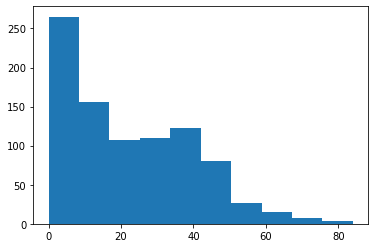

In [6]:
plt.hist(df_KBF['severity']);

(1437, 939, 3)
(1405, 922, 3)
(1421, 826, 3)


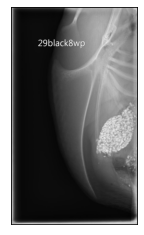

In [7]:
li_path = df_KBF['actual_path_img'].tolist()
for path_ in li_path[0:3]:
    img = cv2.imread(path_)
    print(img.shape)
    plt.imshow(img)
    plt.xticks([]) #remove xlabel annotations
    plt.yticks([])

In [8]:
target_size_ = (224,224)
input_shape_ = (224,224,3)

# Train CNN

In [9]:
pre_trained_model = VGG16(input_shape = input_shape_, include_top = False, weights = 'imagenet')
# Make all the layers in the pre-trained model non-trainable
#for layer in pre_trained_model.layers:
#    layer.trainable = False
#OR
#pre_trained_model = VGG16(include_top = True, weights = 'imagenet')

In [10]:
last_layer = pre_trained_model.get_layer('block5_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 512)


In [11]:
# As we have a continuous output we will flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# and add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='linear')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.00005), 
              loss = 'mean_squared_error',
              metrics = ['mean_absolute_percentage_error','mean_absolute_error']) 

#model.summary()

In [12]:
#generators for the training and validation (splitting 20%_80%)
datagen = ImageDataGenerator( 
            rescale=1./255.,
            rotation_range=5,
            shear_range=0.2,
            zoom_range=0.1,
            horizontal_flip=False,
            validation_split=0.20, #so taht it will split into validation and training
            fill_mode='nearest')    #resize the images without aspect ratio distortion

train_generator=datagen.flow_from_dataframe(
            dataframe=df_train,
            directory=None,
            x_col="actual_path_img",
            y_col="severity",
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="other",
            target_size=target_size_,
            crop_to_aspect_ratio=True)

valid_generator=datagen.flow_from_dataframe(
            dataframe=df_train,
            directory=None,
            x_col="actual_path_img",
            y_col="severity",
            subset="validation",
            batch_size=32,
            seed=42,
            class_mode="other",
            target_size=target_size_,
            crop_to_aspect_ratio=True)

#generators for the testing
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
            dataframe=df_test,
            directory=None,
            x_col="actual_path_img",
            y_col=None,
            batch_size=32,
            seed=42,
            class_mode=None,
            target_size=target_size_,
            crop_to_aspect_ratio=True)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\camil\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\camil\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\camil\anaconda3\lib\site-packages\traitlets\config\a

Found 644 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\camil\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\camil\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\camil\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\camil\anaconda3\lib\site-packages\traitlets\config\a

Found 160 validated image filenames.
Found 90 validated image filenames.


In [13]:
#if not enough improvment on the val loss, then we will reduce the learning rate, and after that if still no change then 
#early stopping 
id_='model_KBF_test'
#The checkpoint only includes the model weights
#save the network weights only when there is an improvement in classification accuracy on the validation dataset 
filepath = os.path.join(path_save_model_info, id_,'weights-improvement-{epoch:02d}-{val_loss:.2f}.h5')
#if save_best_only=True, the latest best model according to the quantity monitored will not be overwritten
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             monitor='val_loss', 
                                             verbose=1, 
                                             save_best_only=False, 
                                             mode='max')

#to reduce learning rate (new_lr = lr*factor) when a metric has stopped improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              patience=1, #patience before changing learning rate
                                              min_delta=0.0001,
                                              verbose=1,
                                              factor=0.1)

#Stop training when a monitored quantity has stopped improving. to avoid overfiting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.001, 
                                               patience=3,
                                               verbose=1, 
                                               mode='auto',
                                               baseline=None)

#create logs data for tensorboard usage
'''tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(path_log,id_), 
                                          histogram_freq=0, #no histo
                                          write_graph=True, 
                                          write_grads=False,
                                          write_images=True)'''

callbacks_list = [reduce_lr, early_stopping, checkpoint]  #tensorboard
#then as usuall to load weights to an instantiate model: model.load_weights("weights.best.hdf5")

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              epochs=50,
                              verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 358.3237 - mean_absolute_percentage_error: 3287352832.0000 - mean_absolute_error: 15.2904
Epoch 00001: saving model to G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput\TrackingSystem\correctlightschedule_\KBF\LOGS\model_KBF_test\weights-improvement-01-249.84.h5
21/21 [==============================] - 237s 11s/step - loss: 358.3237 - mean_absolute_percentage_error: 3287352832.0000 - mean_absolute_error: 15.2904 - val_loss: 249.8404 - val_mean_absolute_percentage_error: 2465576448.0000 - val_mean_absolute_error: 13.3186
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 245.9811 - mean_absolute_percentage_error: 2384911360.0000 - mean_absolute_error: 12.5561 
Epoch 00002: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00002: saving model to G:\VPHI\Welfare\2- Research Projects\OFHE2.Orig

In [ ]:
#save
model.save(os.path.join(path_save_model_info, 'id_'))

# Test

In [ ]:
scores = model.predict_generator(test_generator,verbose=1)
print(df_test.shape, len(scores))
df_test['Predicted'] = scores
#mean absolute percentage error
df_test['APE'] = abs( (df_test['severity'] - df_test['Predicted'] ) / df_test['severity']) * 100

In [ ]:
plt.hist(df_test[~df_test['APE'].isin([np.nan, np.inf, -np.inf])]);

In [ ]:
MSE = mean_squared_error(y_true = df_test['severity'], y_pred = df_test['Predicted'])
RMSE = MSE**(0.5)
print(RMSE, MSE)

In [ ]:
sns.scatterplot(x='severity',y='Predicted',data=df_test);